# 🚖 Uber Use Case Simulation

## 📌 Problem Statement
Uber is a ride-hailing service that connects passengers with drivers. The goal of this notebook is to simulate a simplified Uber-like environment where we analyze ride data to extract useful insights for operational improvements and customer experience enhancement.

We aim to answer key business questions like:
- What are the peak hours for ride demand?
- Which cities generate the most revenue?
- What is the average trip distance and fare?
- How can we identify high-performing drivers?
- How frequently do users cancel rides?

---

## ✅ Solution

We will:
1. Simulate or use a dataset representing ride transactions.
2. Clean and preprocess the data.
3. Perform Exploratory Data Analysis (EDA).
4. Generate actionable insights such as:
   - Ride volume by hour/day
   - Revenue by city
   - Cancellation patterns
   - Driver performance metrics


In [3]:
from cassandra.cluster import Cluster
import uuid
from datetime import datetime, timedelta
from collections import defaultdict, Counter
import random
import pandas as pd

# Step 1: Connect to Cassandra
cluster = Cluster(['127.0.0.1'], port=9042)
session = cluster.connect()

# Step 2: Create Keyspace and Table
session.execute("""
    CREATE KEYSPACE IF NOT EXISTS uber
    WITH replication = {'class': 'SimpleStrategy', 'replication_factor': 1}
""")
session.set_keyspace('uber')
session.execute("""
    CREATE TABLE IF NOT EXISTS rides (
        ride_id UUID PRIMARY KEY,
        rider_id TEXT,
        driver_id TEXT,
        city TEXT,
        status TEXT,
        fare DECIMAL,
        distance_km DECIMAL,
        ride_time TIMESTAMP
    )
""")

# Step 3: Insert 1000 Sample Records
cities = ["Mumbai", "Delhi", "Bangalore", "Chennai", "Hyderabad"]
statuses = ["Completed", "Cancelled", "No Show"]
driver_ids = [f"DR{2000+i}" for i in range(50)]
rider_ids = [f"USR{1000+i}" for i in range(200)]

insert_query = session.prepare("""
    INSERT INTO rides (ride_id, rider_id, driver_id, city, status, fare, distance_km, ride_time)
    VALUES (?, ?, ?, ?, ?, ?, ?, ?)
""")

base_time = datetime(2025, 7, 1)

for _ in range(1000):
    rider_id = random.choice(rider_ids)
    driver_id = random.choice(driver_ids)
    city = random.choice(cities)
    status = random.choices(statuses, weights=[0.85, 0.1, 0.05])[0]
    fare = round(random.uniform(50, 500), 2) if status == "Completed" else 0.0
    distance = round(random.uniform(2, 25), 2) if status == "Completed" else 0.0
    ride_time = base_time + timedelta(minutes=random.randint(0, 60*24*7))

    session.execute(insert_query, (uuid.uuid4(), rider_id, driver_id, city, status, fare, distance, ride_time))

print("\n✅ Inserted 1000 ride records into Cassandra.")


✅ Inserted 1000 ride records into Cassandra.


## 📊 Key Analytics & KPIs

- Total revenue and average fare per city
- Number of rides by status (Completed, Cancelled, No Show)
- Peak demand hours and days
- Driver performance (rides completed, average fare)
- User churn indicators
- Cancellation rate by city or user


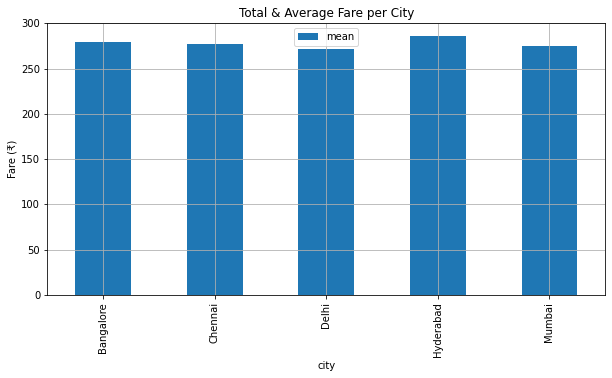

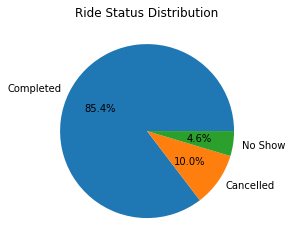

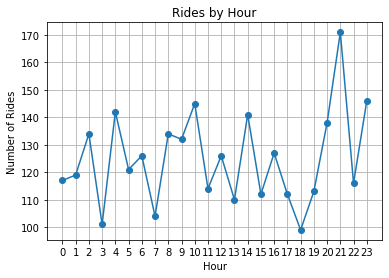

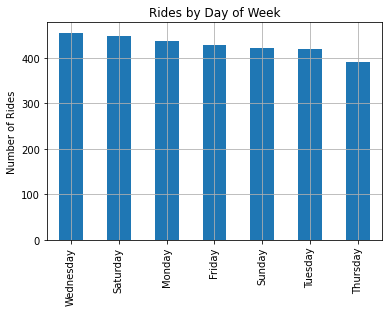


🏅 Top 10 Drivers by Total Completed Rides:
           total_rides    avg_fare
driver_id                         
DR2011              62  254.873710
DR2005              62  290.604194
DR2043              61  283.889180
DR2047              61  286.721311
DR2023              61  275.939508
DR2038              61  266.403607
DR2002              60  272.346000
DR2015              58  269.632586
DR2014              57  253.038772
DR2035              57  274.641228

⚠️ Top 10 Potentially Churning Users:
rider_id
USR1171    7
USR1061    7
USR1192    6
USR1126    6
USR1097    6
USR1071    6
USR1153    5
USR1138    5
USR1121    5
USR1154    5
dtype: int64


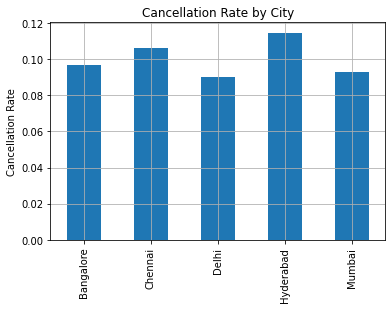

In [4]:
import matplotlib.pyplot as plt
# Step 4: Analytics and Visualization
# Fetch all records for full analytics
rows = session.execute("SELECT * FROM rides")
data = [row._asdict() for row in rows]
df = pd.DataFrame(data)

# Total revenue and average fare per city
city_revenue = df[df['status'] == 'Completed'].groupby('city')['fare'].agg(['sum', 'mean'])
city_revenue.plot(kind='bar', figsize=(10, 5), title='Total & Average Fare per City')
plt.ylabel('Fare (₹)')
plt.grid(True)
plt.show()

# Number of rides by status
status_counts = df['status'].value_counts()
status_counts.plot(kind='pie', autopct='%1.1f%%', title='Ride Status Distribution')
plt.ylabel('')
plt.show()

# Peak demand hours and days
if not df.empty:
    df['hour'] = df['ride_time'].dt.hour
    df['day'] = df['ride_time'].dt.day_name()

    df.groupby('hour').size().plot(kind='line', marker='o', title='Rides by Hour')
    plt.xlabel('Hour')
    plt.ylabel('Number of Rides')
    plt.grid(True)
    plt.xticks(range(24))
    plt.show()

    df['day'].value_counts().plot(kind='bar', title='Rides by Day of Week')
    plt.ylabel('Number of Rides')
    plt.grid(True)
    plt.show()

# Driver performance (rides completed, average fare)
driver_stats = df[df['status'] == 'Completed'].groupby('driver_id').agg(
    total_rides=('ride_id', 'count'),
    avg_fare=('fare', 'mean')
).sort_values('total_rides', ascending=False)
print("\n🏅 Top 10 Drivers by Total Completed Rides:")
print(driver_stats.head(10))

# User churn indicator (number of cancelled/no-show rides per user)
user_churn = df[df['status'] != 'Completed'].groupby('rider_id').size().sort_values(ascending=False)
print("\n⚠️ Top 10 Potentially Churning Users:")
print(user_churn.head(10))

# Cancellation rate by city
cancel_df = df[df['status'] == 'Cancelled']
cancel_rate_by_city = cancel_df['city'].value_counts() / df['city'].value_counts()
cancel_rate_by_city.plot(kind='bar', title='Cancellation Rate by City')
plt.ylabel('Cancellation Rate')
plt.grid(True)
plt.show()